<a href="https://colab.research.google.com/github/tonytarizzo/NeverLateX/blob/main/28_01_2025_imu_only_with_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Set Up the Environment**

In [23]:
# Import required libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [45]:
# Load the datasets
file_paths = {
    "imu_data_1": "imu_data_1.csv",
    "imu_data_2": "imu_data_2.csv",
    "imu_data_3": "imu_data_3.csv"
}

In [69]:
# Load the datasets into pandas DataFrames
datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}

In [70]:
# Display a sample of one dataset to inspect
print(datasets["imu_data_2"].head())
print(datasets["imu_data_3"].head())

                 Timestamp  Acc_X  Acc_Y  Acc_Z  Gyro_X  Gyro_Y  Gyro_Z  \
0  2025-01-28 14:38:21.260     23   -206    978       1      -1      -1   
1  2025-01-28 14:38:21.350     22   -202    974      -2      -1      -1   
2  2025-01-28 14:38:21.457     21   -208    973      -1      -1      -1   
3  2025-01-28 14:38:21.563     21   -207    977      -2      -1      -1   
4  2025-01-28 14:38:21.670     19   -215    971      -1      -1      -1   

   Mag_X  Mag_Y  Mag_Z Letter  
0      8     -4     -1  noise  
1      7     -4     -1  noise  
2      6     -2     -1  noise  
3      7     -4     -2  noise  
4      8     -3     -2  noise  
                 Timestamp  Acc_X  Acc_Y  Acc_Z  Gyro_X  Gyro_Y  Gyro_Z  \
0  2025-01-28 14:50:55.301    696   -174    689      -5      -9       1   
1  2025-01-28 14:50:55.391    699   -183    681      -2      -4      -4   
2  2025-01-28 14:50:55.498    711   -183    669      -1       3      -2   
3  2025-01-28 14:50:55.604    681   -178    695      -2  

# **Step 2: Preprocessing**
Since this is a time-series classification problem, we need to ensure:

1. Input (X): Sequences of sensor values over time.
2. Output (Y): Corresponding labels for the entire sequence.

Let's modify the preprocessing workflow to:

1. Group sensor readings by sequence.
2. Prepare sequences (as X) and their corresponding label (Y).

Updated Workflow for Time-Series Data

1. **Group Data:** Ensure each sequence is grouped by the corresponding Letter.
2. **Create Time-Series Inputs and Labels:** Prepare X as sequences of sensor data for each label. Assign Y as the corresponding label for the sequence.

In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [72]:
# Combine datasets
combined_data = pd.concat([datasets["imu_data_2"], datasets["imu_data_3"]], ignore_index=True)

# Filter out noise
filtered_data = combined_data[combined_data["Letter"] != "noise"]

# Define sensor columns
sensor_columns = ["Acc_X", "Acc_Y", "Acc_Z", "Gyro_X", "Gyro_Y", "Gyro_Z", "Mag_X", "Mag_Y", "Mag_Z"]

# Normalize sensor data (Z-score normalization)
scaler = StandardScaler()
filtered_data[sensor_columns] = scaler.fit_transform(filtered_data[sensor_columns])

<ipython-input-72-a77fab9c238f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data[sensor_columns] = scaler.fit_transform(filtered_data[sensor_columns])


In [73]:
# Function to group data into sequences by label
def create_sequences(data):
    sequences = []
    labels = []
    current_label = None
    current_sequence = []

    for _, row in data.iterrows():
        if row["Letter"] != current_label:
            # Save the current sequence if it's not empty
            if current_sequence:
                sequences.append(np.array(current_sequence))
                labels.append(current_label)
            # Start a new sequence
            current_label = row["Letter"]
            current_sequence = []

        # Append sensor values to the current sequence
        current_sequence.append(row[sensor_columns].values)

    # Save the final sequence
    if current_sequence:
        sequences.append(np.array(current_sequence))
        labels.append(current_label)

    return np.array(sequences, dtype=object), labels

In [74]:
# Create sequences and labels
sequences, labels = create_sequences(filtered_data)

# Map labels to integer indices
unique_labels = list(set(labels))
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
indexed_labels = [label_to_index[label] for label in labels]

In [75]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define padding parameters
max_length = max([len(seq) for seq in sequences])  # Longest sequence
min_length = 10  # Minimum acceptable length for sequences

# Filter out very short sequences
filtered_sequences = [seq for seq in sequences if seq.shape[0] >= min_length]
filtered_labels = [label for seq, label in zip(sequences, indexed_labels) if seq.shape[0] >= min_length]

# Pad sequences to the same length
padded_sequences = pad_sequences(filtered_sequences, maxlen=max_length, padding='post', dtype='float32')

# Verify the new shapes
print(f"Padded Sequences Shape: {padded_sequences.shape}")
print(f"Filtered Labels Count: {len(filtered_labels)}")


Padded Sequences Shape: (124, 27, 9)
Filtered Labels Count: 124


In [76]:
''' for seq, label in zip(padded_sequences, filtered_labels):
    print(f"Sequence Shape: {seq.shape}, Label: {label}") '''

' for seq, label in zip(padded_sequences, filtered_labels):\n    print(f"Sequence Shape: {seq.shape}, Label: {label}") '

In [77]:
X_train, X_test, y_train, y_test = padded_sequences, padded_sequences, filtered_labels,  filtered_labels

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {len(y_train)}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {len(y_test)}")

X_train shape: (124, 27, 9)
y_train shape: 124
X_test shape: (124, 27, 9)
y_test shape: 124


# **Step 3: Model Design**
We’ll implement two models:

* **CNN Model:** Four 1D convolutional layers. Batch normalization, ReLU activation, and max pooling after each convolutional layer. Fully connected layer for classification.
* **CLDNN Model:** Three 1D convolutional layers. Two BLSTM layers for temporal modeling. Fully connected layer for final output.






In [78]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Conv1D, BatchNormalization, ReLU, MaxPooling1D, Dense, Dropout, Flatten, Activation, Bidirectional, LSTM
import tensorflow as tf

def create_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(1024, kernel_size=5, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(512, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv1D(128, kernel_size=3, padding="same")(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    # Ensure time-distributed outputs
    x = TimeDistributed(Dense(num_classes))(x)
    outputs = Activation('softmax')(x)  # ✅ Corrected

    return tf.keras.Model(inputs, outputs)



In [79]:
from tensorflow.keras.layers import LSTM, Bidirectional, TimeDistributed

def create_cldnn_model(input_shape, num_classes):
    model = Sequential([
        # Convolutional layers
        Conv1D(512, kernel_size=5, padding="same", input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(256, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        Conv1D(128, kernel_size=3, padding="same"),
        BatchNormalization(),
        ReLU(),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),

        # Bidirectional LSTMs
        Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),
        Dropout(0.3),

        Bidirectional(LSTM(64, return_sequences=True, activation="tanh")),  # Set return_sequences=True
        Dropout(0.3),

        # TimeDistributed dense layers for sequence output
        TimeDistributed(Dense(100, activation="relu")),
        TimeDistributed(Dense(num_classes, activation="softmax"))  # Keep softmax for output distribution
    ])
    return model

In [80]:
# Get input shape and number of classes
input_shape = X_train.shape[1:]  # (27, 9) from your padded sequences
num_classes = len(set(y_train))  # Unique labels in y_train

print(f"Input Shape: {input_shape}")
print(f"Number of Classes: {num_classes}")

# Create CNN Model
cnn_model = create_cnn_model(input_shape, num_classes)
print("CNN Model Summary:")
cnn_model.summary()

# Create CLDNN Model
cldnn_model = create_cldnn_model(input_shape, num_classes)
print("\nCLDNN Model Summary:")
cldnn_model.summary()


Input Shape: (27, 9)
Number of Classes: 62
CNN Model Summary:


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 27, 9)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_21 (Conv1D)                   │ (None, 27, 1024)            │          47,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_21               │ (None, 27, 1024)            │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_21 (ReLU)                      │ (None, 27, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_21 (MaxPooling1D)      │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 13, 1024)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_22 (Conv1D)                   │ (None, 13, 512)             │       1,573,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_22               │ (None, 13, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_22 (ReLU)                      │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_22 (MaxPooling1D)      │ (None, 6, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 6, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_23 (Conv1D)                   │ (None, 6, 256)              │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_23               │ (None, 6, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_23 (ReLU)                      │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_23 (MaxPooling1D)      │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 3, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_24 (Conv1D)                   │ (None, 3, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 3, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_24 (ReLU)                      │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,128,062 (8.12 MB)

 Trainable params: 2,124,222 (8.10 MB)

 Non-trainable params: 3,840 (15.00 KB)


CLDNN Model Summary:


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_25 (Conv1D)                   │ (None, 27, 512)             │          23,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 27, 512)             │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_25 (ReLU)                      │ (None, 27, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_25 (MaxPooling1D)      │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 13, 512)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_26 (Conv1D)                   │ (None, 13, 256)             │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 13, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_26 (ReLU)                      │ (None, 13, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_26 (MaxPooling1D)      │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 6, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_27 (Conv1D)                   │ (None, 6, 128)              │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_27               │ (None, 6, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_27 (ReLU)                      │ (None, 6, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_27 (MaxPooling1D)      │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ (None, 3, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_34 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 3, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_35 (Dropout)                 │ (None, 3, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 3, 100)              │          12,9

 Total params: 735,834 (2.81 MB)

 Trainable params: 734,042 (2.80 MB)

 Non-trainable params: 1,792 (7.00 KB)

# **Step 4: Model Compilation and Training**

We’ll now:

* Compile the models with the CTC loss.
* Set up an optimizer (Adam) and learning rate scheduler as described in the paper.
* Train the models with early stopping based on validation loss.

## **Step 4.1: Preprocessing and Loss Function Definition**

In [81]:
# Reshape X_train and X_test to ensure they match the model input shape
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Define lengths
input_length = np.full((len(X_train),), X_train.shape[1], dtype=np.int32)  # All inputs have the same time steps

y_train = [[label] for label in y_train]
y_test = [[label] for label in y_test]

label_length = np.array([len(label) for label in y_train])  # Actual label lengths

print(f"Input Length Shape: {input_length.shape}")
print(f"Label Length Shape: {label_length.shape}")

X_train shape: (124, 27, 9)
X_test shape: (124, 27, 9)
Input Length Shape: (124,)
Label Length Shape: (124,)


In [82]:
# Ensure labels are padded
from tensorflow.keras.preprocessing.sequence import pad_sequences

batch_size = 64

# Ensure y_train and y_test are sequences
if isinstance(y_train[0], int):
    y_train = [[label] for label in y_train]
if isinstance(y_test[0], int):
    y_test = [[label] for label in y_test]

max_label_length = max([len(label) for label in y_train + y_test])

y_train_padded = pad_sequences(y_train, maxlen=max_label_length, padding="post", value=0)
y_test_padded = pad_sequences(y_test, maxlen=max_label_length, padding="post", value=0)

print(f"y_train_padded shape: {y_train_padded.shape}")
print(f"y_test_padded shape: {y_test_padded.shape}")

# Update the dataset
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train_padded, input_length, label_length))
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test_padded, input_length, label_length))
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)


y_train_padded shape: (124, 1)
y_test_padded shape: (124, 1)


In [83]:
def ctc_loss_fn(y_true, y_pred):
    # Cast labels to int32
    y_true = tf.cast(y_true, dtype=tf.int32)

    # Input length: Number of time steps for each input
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])

    # Label length: Actual length of each label
    label_length = tf.reduce_sum(tf.cast(tf.not_equal(y_true, 0), dtype=tf.int32), axis=1)

    # Compute CTC loss
    return tf.reduce_mean(
        tf.nn.ctc_loss(
            labels=y_true,
            logits=y_pred,
            label_length=label_length,
            logit_length=input_length,
            logits_time_major=False,
            blank_index=-1,  # Use the last class as the blank label
        )
    )

In [84]:
# Map dataset to (x, y)
train_dataset_simple = train_dataset.map(lambda x, y, il, ll: (x, y))
val_dataset_simple = val_dataset.map(lambda x, y, il, ll: (x, y))

In [85]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-4)

In [63]:
''' from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=1e-4)

cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn)

cnn_history = cnn_model.fit(
    train_dataset_simple,
    validation_data=val_dataset_simple,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
) '''

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 4.1269 - val_loss: 4.1128 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step - loss: 4.1058 - val_loss: 4.1205 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - loss: 4.0926 - val_loss: 4.1317 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step - loss: 4.0584 - val_loss: 4.1221 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - loss: 4.0614 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step - loss: 4.0569 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 825ms/step - loss: 4.0457 - val_loss: 4.1383 - learning_rate: 0.0080
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 550ms/step - loss: 4.0330 - val_loss: 4.1383 - learning_rate: 0.0080
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 555ms/step - loss: 4.0057 - val_loss: 4.1303 - learning_rate: 0.0080
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━

## **Step 4.2: Decoding for Accuracy**

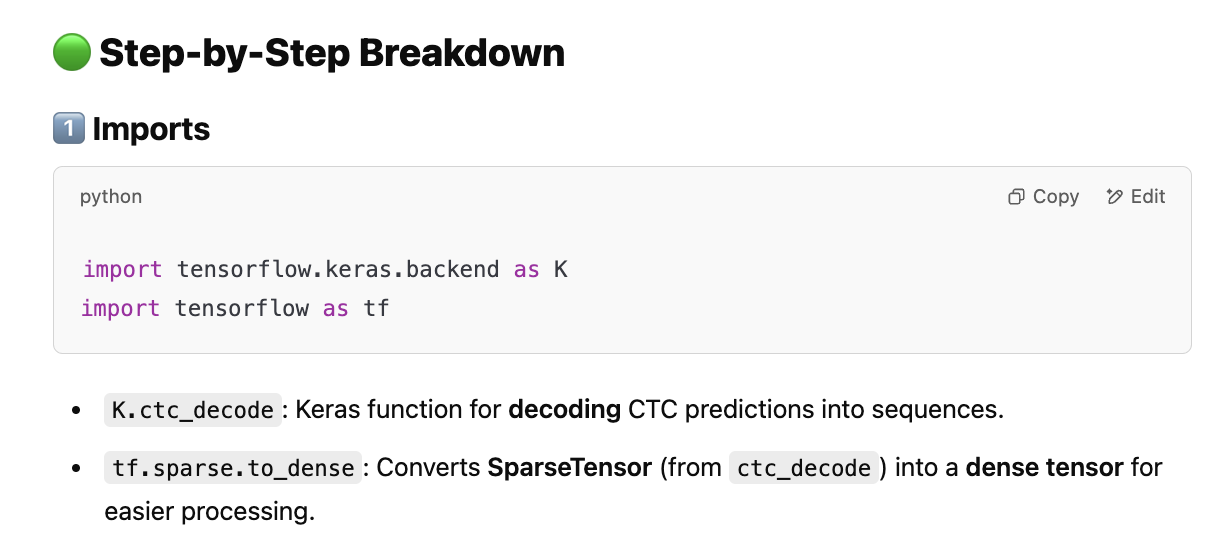

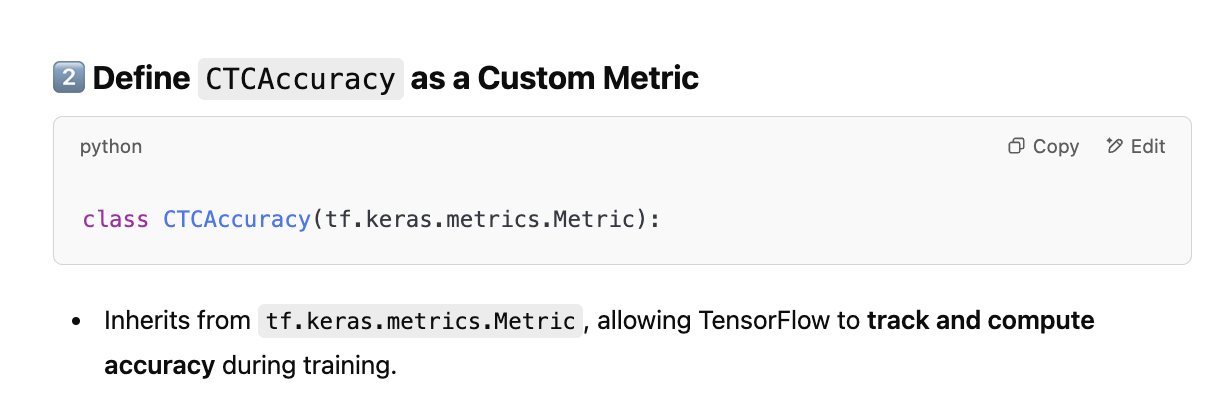

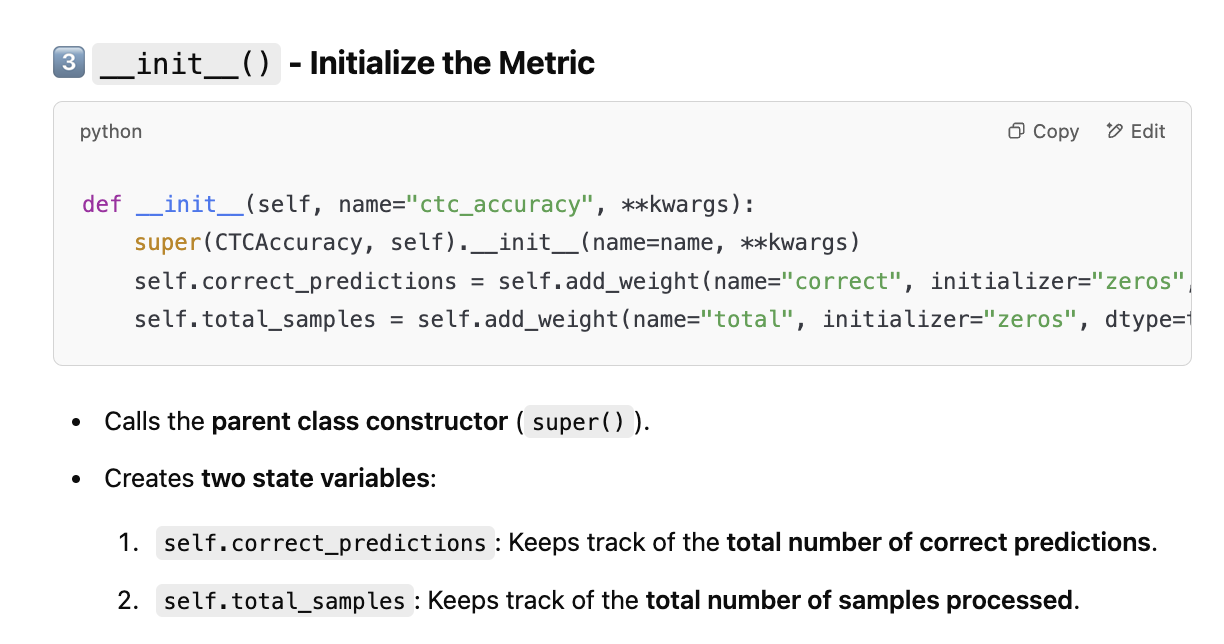

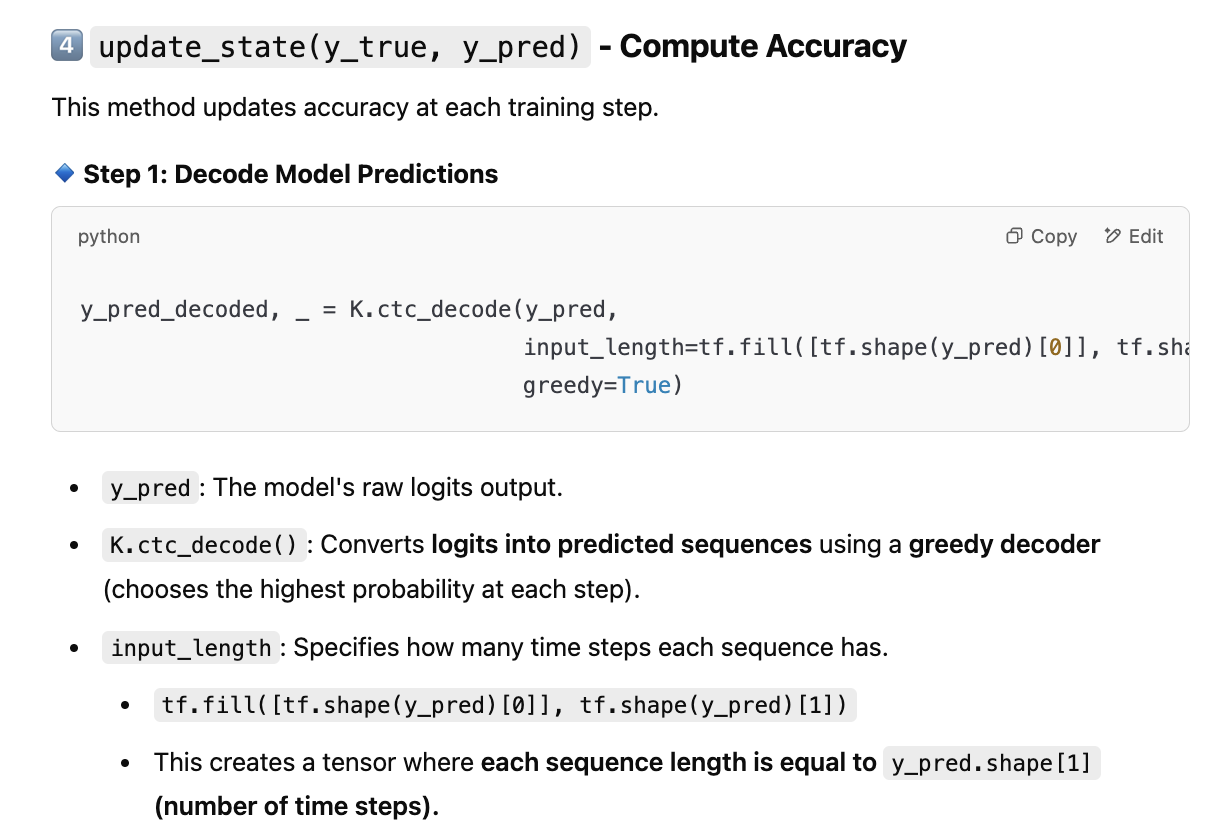

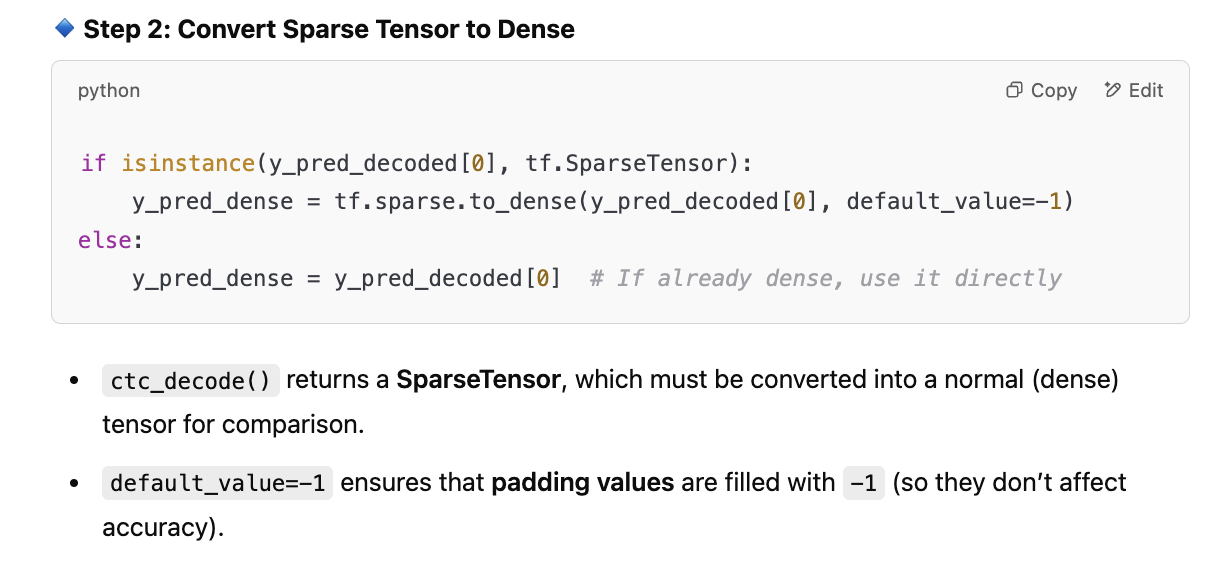

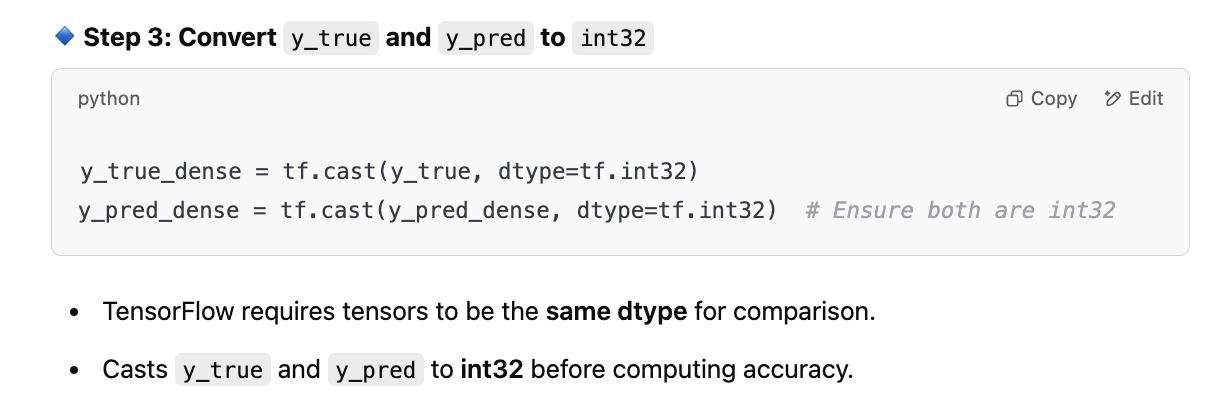

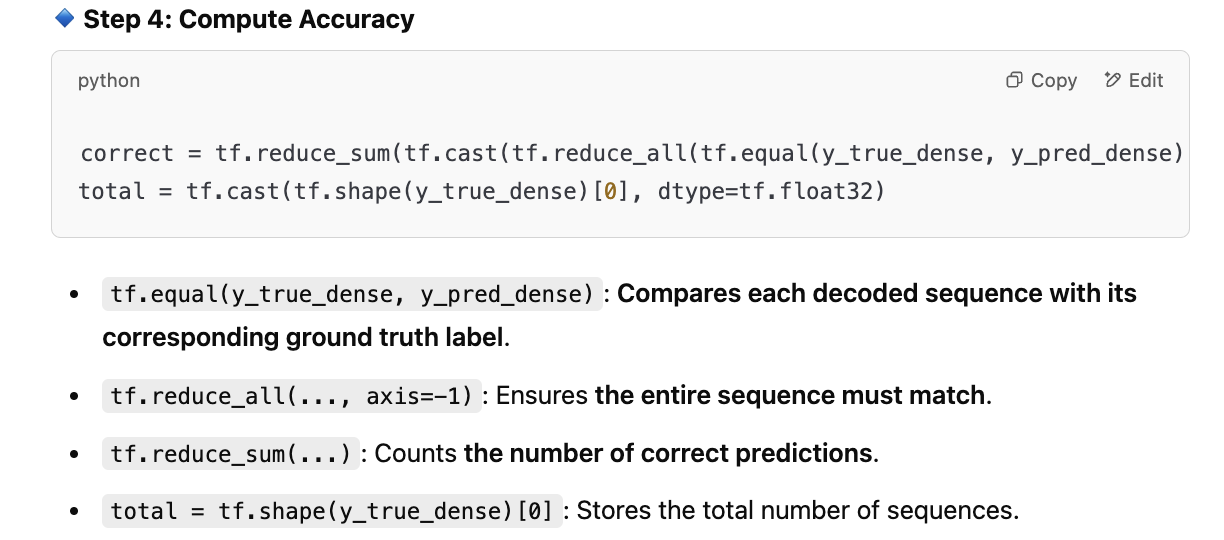

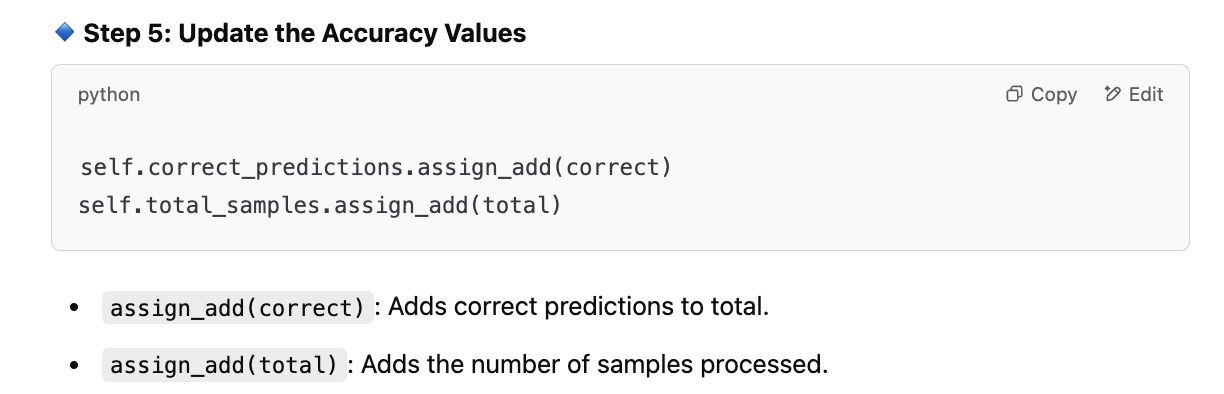

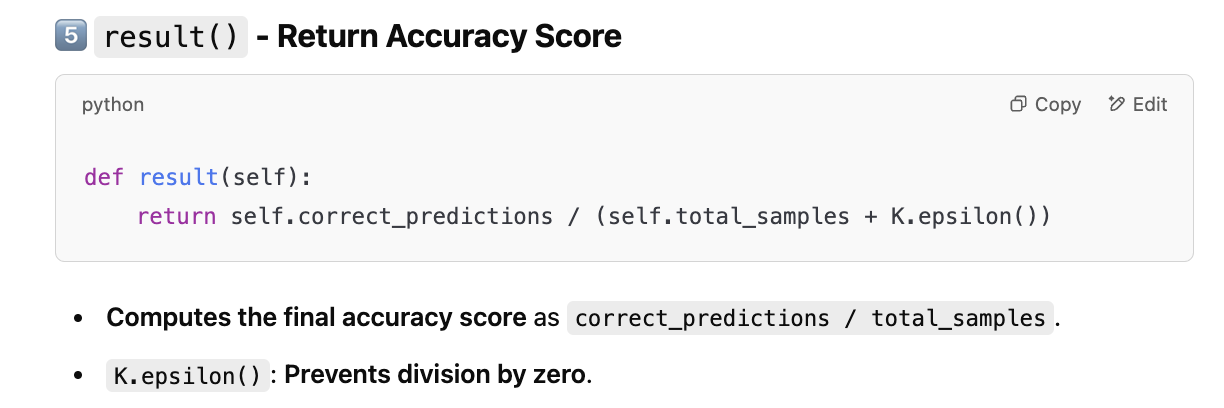

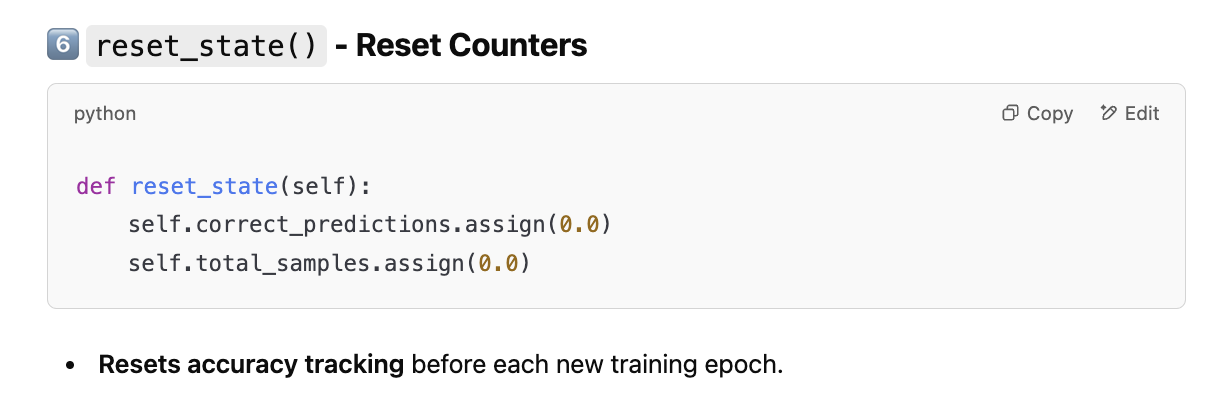

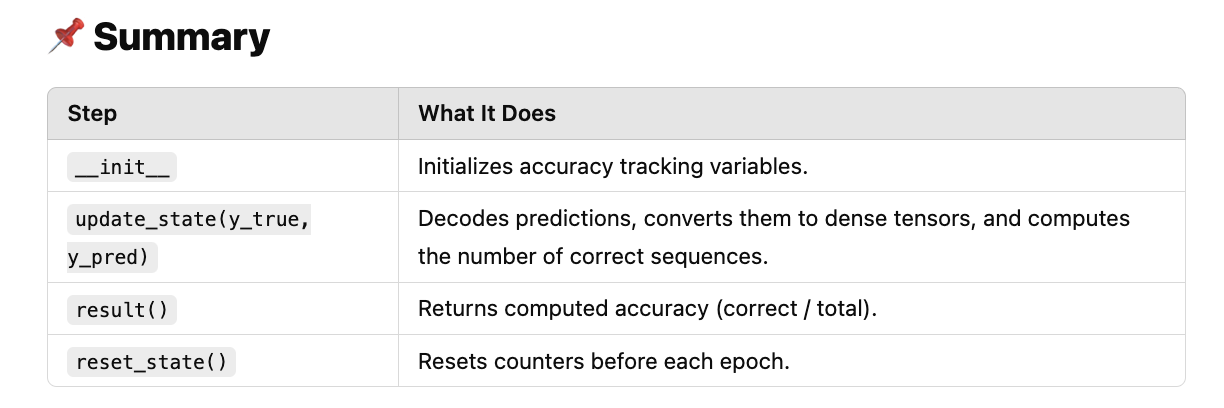

In [86]:
import tensorflow.keras.backend as K
import tensorflow as tf

class CTCAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="ctc_accuracy", **kwargs):
        super(CTCAccuracy, self).__init__(name=name, **kwargs)
        self.correct_predictions = self.add_weight(name="correct", initializer="zeros", dtype=tf.float32)
        self.total_samples = self.add_weight(name="total", initializer="zeros", dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Decode predictions using greedy search
        y_pred_decoded, _ = K.ctc_decode(y_pred,
                                         input_length=tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1]),
                                         greedy=True)

        # Ensure we are working with a sparse tensor before converting to dense
        if isinstance(y_pred_decoded[0], tf.SparseTensor):
            y_pred_dense = tf.sparse.to_dense(y_pred_decoded[0], default_value=-1)
        else:
            y_pred_dense = y_pred_decoded[0]  # If already dense, use it directly

        # Convert ground truth labels to int32
        y_true_dense = tf.cast(y_true, dtype=tf.int32)
        y_pred_dense = tf.cast(y_pred_dense, dtype=tf.int32)  # Ensure both are int32

        # Compute correct predictions by checking element-wise equality
        correct = tf.reduce_sum(tf.cast(tf.reduce_all(tf.equal(y_true_dense, y_pred_dense), axis=-1), dtype=tf.float32))
        total = tf.cast(tf.shape(y_true_dense)[0], dtype=tf.float32)

        # Update the accuracy metric
        self.correct_predictions.assign_add(correct)
        self.total_samples.assign_add(total)

    def result(self):
        return self.correct_predictions / (self.total_samples + K.epsilon())

    def reset_state(self):
        self.correct_predictions.assign(0.0)
        self.total_samples.assign(0.0)

In [65]:
# Instantiate the accuracy metric
ctc_accuracy = CTCAccuracy()

# Compile the model with CTC loss and accuracy tracking
cnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn, metrics=[ctc_accuracy])

cnn_history = cnn_model.fit(
    train_dataset_simple,
    validation_data=val_dataset_simple,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - ctc_accuracy: 0.0531 - loss: 4.1097 - val_ctc_accuracy: 0.0161 - val_loss: 4.1367 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - ctc_accuracy: 0.0586 - loss: 4.0964 - val_ctc_accuracy: 0.0161 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step - ctc_accuracy: 0.0533 - loss: 4.0856 - val_ctc_accuracy: 0.0323 - val_loss: 4.1221 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step - ctc_accuracy: 0.0692 - loss: 4.0687 - val_ctc_accuracy: 0.0161 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 966ms/step - ctc_accuracy: 0.0958 - loss: 4.0643 - val_ctc_accuracy: 0.0161 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 983ms/step - ctc_accuracy: 0.1011 - loss: 4.0494 - val_ctc_accuracy: 0.0161 - val_loss: 4.1383 - learning_rate: 0.0100
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 548ms/step - ctc

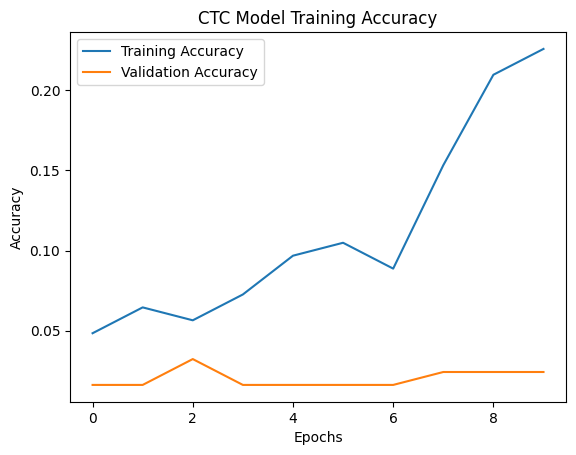

In [87]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['ctc_accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_ctc_accuracy'], label='Validation Accuracy')
plt.title('CTC Model Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [88]:
# Instantiate the accuracy metric
ctc_accuracy = CTCAccuracy()

# Compile the model with CTC loss and accuracy tracking
cldnn_model.compile(optimizer=Adam(learning_rate=0.01), loss=ctc_loss_fn, metrics=[ctc_accuracy])

cldnn_history = cldnn_model.fit(
    train_dataset_simple,
    validation_data=val_dataset_simple,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - ctc_accuracy: 0.0000e+00 - loss: 10.6152 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.9815 - learning_rate: 0.0100
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step - ctc_accuracy: 0.0000e+00 - loss: 9.5566 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.1156 - learning_rate: 0.0100
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - ctc_accuracy: 0.0000e+00 - loss: 9.1174 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.1156 - learning_rate: 0.0100
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - ctc_accuracy: 0.0000e+00 - loss: 9.1174 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.1156 - learning_rate: 0.0100
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - ctc_accuracy: 0.0000e+00 - loss: 9.1174 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.1156 - learning_rate: 0.0100
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - ctc_accuracy: 0.0000e+00 - loss: 9.1174 - val_ctc_accuracy: 0.0000e+00 - val_loss: 9.1156 - learning_rate: 0.0100
Epoch

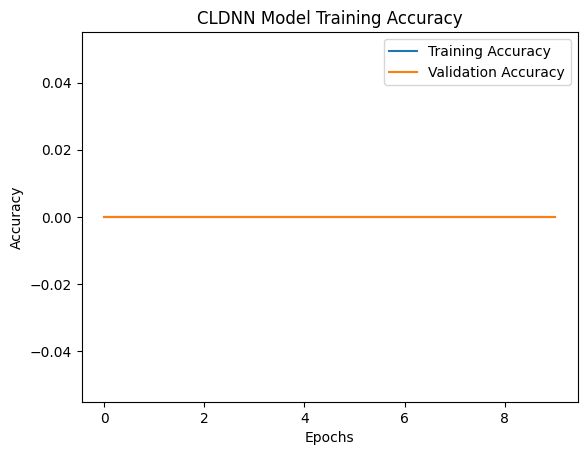

In [68]:
import matplotlib.pyplot as plt

plt.plot(cldnn_history.history['ctc_accuracy'], label='Training Accuracy')
plt.plot(cldnn_history.history['val_ctc_accuracy'], label='Validation Accuracy')
plt.title('CLDNN Model Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()